# Проект для «Викишоп»

## Подготовка

In [1]:
# импорт библиотек
!pip3 install catboost
! pip install optuna
import optuna
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 308 kB 1.1 MB/s            
     |████████████████████████████████| 81 kB 4.1 MB/s             
     |████████████████████████████████| 112 kB 19.1 MB/s            
     |████████████████████████████████| 49 kB 7.1 MB/s             
     |████████████████████████████████| 146 kB 19.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=47cdd52efe8fdab5cccfda436baaa163cfd34a1d8d69d85981a16828e93628f2
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# подключение Google Диск к Google Colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# чтение файла с данными и сохранение в df с использованием конструкции try-except
try:
  df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
  df = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')

In [6]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
# просмотр первых 5 строк таблицы df
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


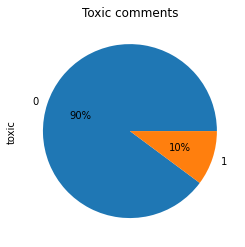

In [8]:
# визуализация распределения столбца toxic
df['toxic'].value_counts().plot(kind='pie', title='Toxic comments', autopct='%1.0f%%');

Наблюдается дисбаланс классов, так как токсичных комментариев существенно меньше позитивных.

In [3]:
# создание функции лемматизации и очистки текста
def lemmatize_clear(text): 
    tokens = nltk.word_tokenize(text) # разбиваем текст комментария на слова
    lemmatizer = WordNetLemmatizer()                                        # cоздаем экземпляр WordNetLemmatizer()
    token_lem = ' '.join([lemmatizer.lemmatize(token) for token in tokens]) # вызываем функцию lemmatize() для каждого слова
    clear_text = ' '.join(re.sub(r'[^a-zA-Z]', ' ', token_lem).split()) # очищаем лемматизированный текст
    return clear_text

# очищаем и лемматизируем текст
corpus = []
for comment in df['text']: 
    corpus.append(lemmatize_clear(comment))

print(df['text'][0])
print('')
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalism just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now


In [4]:
# создание переменных с целевым признаком и признаками
features = corpus
target = df['toxic']

# разделение данных на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [5]:
# вычисление TF-IDF для обучающей и тестовой выборок
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

## Обучение

In [18]:
# LogisticRegression

def objective(trial):
  logreg_c = trial.suggest_float('logreg_c', 0.1, 100, log=True)
  LR = LogisticRegression(random_state=12345, class_weight='balanced', C=logreg_c)
  score = (cross_val_score(LR, features_train, target_train, n_jobs=-1, cv=5, scoring='f1')).mean()
  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print('')
print(f'The best value is : \n{study.best_value}')
print(f'The best parameters are : \n{study.best_params}')

[I 2022-05-18 19:17:31,724] A new study created in memory with name: no-name-daef3e72-8099-4346-85a8-4e5442a60750
[I 2022-05-18 19:17:40,905] Trial 0 finished with value: 0.7277096437924673 and parameters: {'logreg_c': 0.3412978281559831}. Best is trial 0 with value: 0.7277096437924673.
[I 2022-05-18 19:18:03,894] Trial 1 finished with value: 0.7602330444881803 and parameters: {'logreg_c': 11.120778556887993}. Best is trial 1 with value: 0.7602330444881803.
[I 2022-05-18 19:18:13,004] Trial 2 finished with value: 0.7181912213920331 and parameters: {'logreg_c': 0.2023854291144516}. Best is trial 1 with value: 0.7602330444881803.
[I 2022-05-18 19:18:35,438] Trial 3 finished with value: 0.7493694726840036 and parameters: {'logreg_c': 66.60458357095095}. Best is trial 1 with value: 0.7602330444881803.
[I 2022-05-18 19:18:41,984] Trial 4 finished with value: 0.7075997478367493 and parameters: {'logreg_c': 0.12485000221902413}. Best is trial 1 with value: 0.7602330444881803.



The best value is : 
0.7602330444881803
The best parameters are : 
{'logreg_c': 11.120778556887993}


In [11]:
# DecisionTreeClassifier

def objective(trial):
  depth = trial.suggest_int('depth', 10, 60)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
  tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
  score = (cross_val_score(tree, features_train, target_train, n_jobs=-1, cv=5, scoring='f1')).mean()
  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print('')
print(f'The best value is : \n{study.best_value}')
print(f'The best parameters are : \n{study.best_params}')

[I 2022-05-18 18:12:57,619] A new study created in memory with name: no-name-85d78d6a-8f6c-49c0-8a16-b7fba8db3f78
[I 2022-05-18 18:14:17,510] Trial 0 finished with value: 0.5892351130975655 and parameters: {'depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.5892351130975655.
[I 2022-05-18 18:16:22,966] Trial 1 finished with value: 0.5955528254685809 and parameters: {'depth': 40, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.5955528254685809.
[I 2022-05-18 18:17:44,852] Trial 2 finished with value: 0.5956486202676156 and parameters: {'depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.5956486202676156.
[I 2022-05-18 18:19:34,384] Trial 3 finished with value: 0.6182797368062599 and parameters: {'depth': 32, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.6182797368062599.
[I 2022-05-18 18:20:49,872] Trial 4 finished with value: 0.5810370200607307


The best value is : 
0.6182797368062599
The best parameters are : 
{'depth': 32, 'min_samples_split': 20, 'min_samples_leaf': 3}


In [ ]:
# CatBoostClassifier
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.4)
    ctbst = CatBoostClassifier(verbose=False, loss_function='Logloss', learning_rate=learning_rate, task_type='GPU')
    score = (cross_val_score(ctbst, features_train, target_train, cv=3, scoring='f1')).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)

print('')
print(f'The best parameters are : \n{study.best_params}')

[I 2022-05-19 18:23:22,645] A new study created in memory with name: no-name-ebdc3eb9-636b-4fb2-80bf-d810635d0dce


In [14]:
# SGDClassifier
def objective(trial):
  eta0 = trial.suggest_float('eta0', 0.01, 1)

  SGD = SGDClassifier(random_state=12345, class_weight='balanced', eta0=eta0)
  score = (cross_val_score(SGD, features_train, target_train, n_jobs=-1, cv=5, scoring='f1')).mean()
  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print('')
print(f'The best value is : \n{study.best_value}')
print(f'The best parameters are : \n{study.best_params}')

[I 2022-05-18 19:14:34,681] A new study created in memory with name: no-name-812821cc-bf9e-40c0-9914-05494daf6de7
[I 2022-05-18 19:14:38,902] Trial 0 finished with value: 0.7314271629291681 and parameters: {'eta0': 0.9086680268203222}. Best is trial 0 with value: 0.7314271629291681.
[I 2022-05-18 19:14:40,616] Trial 1 finished with value: 0.7314271629291681 and parameters: {'eta0': 0.6803062067800164}. Best is trial 0 with value: 0.7314271629291681.
[I 2022-05-18 19:14:42,321] Trial 2 finished with value: 0.7314271629291681 and parameters: {'eta0': 0.5426140144358418}. Best is trial 0 with value: 0.7314271629291681.
[I 2022-05-18 19:14:44,063] Trial 3 finished with value: 0.7314271629291681 and parameters: {'eta0': 0.8633582416189232}. Best is trial 0 with value: 0.7314271629291681.
[I 2022-05-18 19:14:45,800] Trial 4 finished with value: 0.7314271629291681 and parameters: {'eta0': 0.9135996895648704}. Best is trial 0 with value: 0.7314271629291681.



The best value is : 
0.7314271629291681
The best parameters are : 
{'eta0': 0.9086680268203222}


## Выводы

Было обучено 4 модели: LogisticRegression, CatBoostClassifier, SGDClassifier и DecisionTreeClassifier. Лучшее значение метрики f1 показала логистическая регрессия. Проверим, какое значение данная модель покажет на тестовой выборке.

In [15]:
model = LogisticRegression(random_state=12345, class_weight='balanced', C=22.274927408131955)

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print(f1_score(target_test, predictions))

0.7630911188004613


Таким образом, на тестовых данных значение метрики оказалось чуть выше и составила 0.76